In [ ]:
########################################################################################################################
# Filename: RNN_Models.ipynb
#
# Purpose: Multi-label Text-categorization via recurrent neural networks

# Author(s): Bobby (Robert) Lumpkin
#
# Library Dependencies: numpy, pandas, scikit-learn, skmultilearn, joblib, os, sys, threshold_learning
########################################################################################################################

# Multilabel Text Classification with Recurrent Neural Networks

In [1]:
import numpy as np
import pandas as pd
import math
import os
import json
import ast
import random
from joblib import dump, load
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from bpmll import bp_mll_loss
import sklearn_json as skljson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
os.chdir('C:\\Users\\rober\\OneDrive\\Documents\\Multilabel-Text-Classification\\Deep Learning Models\\RNN Models')  ## Set working directory
                                                                                                                      ## to be 'ANN Results'
sys.path.append('../../ThresholdFunctionLearning')    ## Append path to the ThresholdFunctionLearning directory to the interpreters
                                                   ## search path
from threshold_learning import predict_test_labels_binary    ## Import the 'predict_test_labels_binary()' function from the 
from threshold_learning import predict_labels_binary         ## threshold_learning library
sys.path.append('../FF Models/GridSearchAid_FFNetworks')
from FFNN_gridSearch_aid import SizeLayersPows2, createModel

In [2]:
## Set config values
learning_rates_list = [0.1, 0.01, 0.001]
path_to_models = 'Models'
path_to_CE_training_histories = 'Training Histories/CE_histories.npz'

In [3]:
## Load the sequence of integers training/test data
npzfile = np.load("../../Data/seq_trainTest_data.npz")
X_train_padded = npzfile['train_padded']
X_test_padded = npzfile['test_padded']
Y_train = npzfile['Y_train'].astype('float64')
Y_test = npzfile['Y_test'].astype('float64')
num_unique_words = npzfile['num_unique_words']

In [4]:
SizeLayersPows2(4, 32, 827)[0:3]

[32, 128, 256]

# Cross Entropy Models -- Traditional ("Naive") Approach

In [6]:
%%capture
## Define the LSTM RNN architecture
num_labels = Y_train.shape[1]
embedding_size_list = SizeLayersPows2(4, 32, 827)[0:3]
input_length = X_train_padded.shape[1]

model_dict = {}
histories_dict = {}
histories_df_dict = {}
for learning_rate in learning_rates_list:
    for embedding_size in embedding_size_list:
        hidden_size = int(embedding_size / 2)
        model_biLSTM = tf.keras.models.Sequential([
            tf.keras.layers.Embedding(num_unique_words, embedding_size, input_length = input_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, 
                                                               return_sequences = False, 
                                                               return_state = False)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_labels, activation = 'sigmoid')
        ])

        optim = tf.keras.optimizers.Adam(lr = learning_rate)
        #optim = tf.keras.optimizers.Adagrad(
        #    learning_rate = 0.001, initial_accumulator_value = 0.1, epsilon = 1e-07,
        #    name = 'Adagrad')

        #optim = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum = 0.8, epsilon=1e-07,)

        metric = tfa.metrics.HammingLoss(mode = 'multilabel', threshold = 0.5)
        model_biLSTM.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = metric)
    
        tf.random.set_seed(123)
        history = model_biLSTM.fit(X_train_padded, Y_train, epochs = 15, validation_data = (X_test_padded, Y_test), verbose = 0)
        name = f"model_{embedding_size}_ce_{learning_rate}"
        name = name.replace('.', '')
        model_dict[name] = model_biLSTM
        histories_dict[name] = history
        histories_df_dict[name] = pd.DataFrame(history.history)
        history_name = name + 'history_df'
        exec(history_name + ' = pd.DataFrame(history.history)')

In [10]:
## (NOTE: IF RUNNING PREVIOUS CELL, SKIP THIS CELL) -- Load training histories
histories = np.load(path_to_CE_training_histories, allow_pickle = True)
history_cols = ['loss', 'hamming_loss', 'val_loss', 'val_hamming_loss']
for learning_rate in learning_rates_list:
    for embedding_size in embedding_size_list:
        history_name = f"model_{embedding_size}_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        exec_string = f"{history_name} = histories['{history_name}']"
        exec(exec_string)
        exec_string2 = f"{history_name} = pd.DataFrame({history_name}, columns = history_cols)"
        exec(exec_string2)

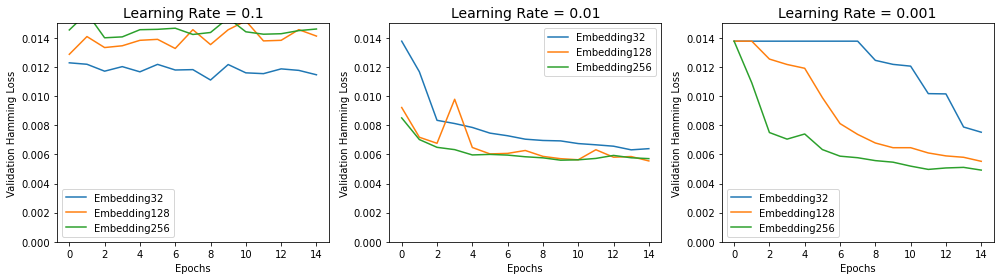

In [11]:
## Visualize the 'val_hamming_loss' histories for each model by learning rate
fig = plt.figure(figsize = (14, 4))
i = 1
for learning_rate in learning_rates_list:
    for embedding_size in embedding_size_list:
        history_name = f"model_{embedding_size}_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        val_loss_name = f"model_{embedding_size}_val_hamming_loss"
        val_loss_name = val_loss_name.replace('.', '')
        exec(val_loss_name + ' = ' + history_name + '.val_hamming_loss')
        
    subplot_string = f"""ax{i} = fig.add_subplot(13{i})
ax{i}.plot(model_32_val_hamming_loss, label = 'Embedding' + str(32))
ax{i}.plot(model_128_val_hamming_loss, label = 'Embedding' + str(128))
ax{i}.plot(model_256_val_hamming_loss, label = 'Embedding' + str(256))
ax{i}.set_ylim(0, 0.015)
ax{i}.set_xlabel('Epochs')
ax{i}.set_ylabel('Validation Hamming Loss')
ax{i}.legend()
ax{i}.set_title('Learning Rate = ' + str({learning_rate}), fontsize = 14)"""
    exec(subplot_string)
    i += 1
fig.tight_layout()

In [27]:
## Try applying a learned threshold function -- (Takes a few minutes to run)
#selected_model = model_dict['model_256_ce_0001']    ## If ran training cell
selected_model = tf.keras.models.Sequential([
                     tf.keras.layers.Embedding(num_unique_words, 256, input_length = input_length),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_size, 
                                                                        return_sequences = False, 
                                                                        return_state = False)),
                     tf.keras.layers.Dropout(0.5),
                     tf.keras.layers.Dense(num_labels, activation = 'sigmoid')
                 ])

optim = tf.keras.optimizers.Adam(lr = 0.001)   ## If loading histories and model
metric = tfa.metrics.HammingLoss(mode = 'multilabel', threshold = 0.5)
selected_model.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = metric)
                       
selected_model.load_weights(path_to_models + '/RNN_ce_best')

# Learn a threshold function
Y_train_pred_proba_array = selected_model.predict(X_train_padded)
Y_test_pred_proba_array = selected_model.predict(X_test_padded)

t_range = (0, 1)

#test_labels_binary, threshold_function = predict_test_labels_binary(Y_train_pred_proba_array, Y_train, Y_test_pred_proba_array, t_range)
threshold_function = load(path_to_models + '/RNN_ce_best_thresholdFunction')
test_labels_binary = predict_labels_binary(Y_test_pred_proba_array, threshold_function)

ce_val_hamming_loss_withThreshold = metrics.hamming_loss(Y_test, test_labels_binary)
ce_val_hamming_loss_withThreshold

0.007530087225350557

In [26]:
## (CAUTION: DO NOT OVERWRITE EXISTING FILES) -- Write training histories to .npz file and save best model 
outfile = path_to_CE_training_histories  
save_string = 'np.savez_compressed(outfile'
for learning_rate in learning_rates_list:
    for embedding_size in embedding_size_list:
        history_name = f"model_{embedding_size}_ce_{learning_rate}" + 'history_df'
        history_name = history_name.replace('.', '')
        save_string = save_string + f", \n {history_name} = {history_name}"
        
save_string = save_string + ')'   
#exec(save_string)

#selected_model = model_dict['model_256_ce_0001']
#selected_model.save_weights(path_to_models + '/RNN_ce_best')
#dump(threshold_function, path_to_models + '/RNN_ce_best_thresholdFunction', compress = 3)

['Models/RNN_ce_best_thresholdFunction']

# BPMLL Models -- "Novel" Approach